In [1]:
import socket

In [2]:
socket.gethostname()

'salish.eos.ubc.ca'

In [3]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, geo_tools, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import pytz
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [4]:
flist=['search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170217T003041Z_20170315T031911Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170315T031912Z_20170404T195130Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170404T195131Z_20170426T173215Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170426T173216Z_20170522T011843Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170522T011844Z_20170611T234016Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170611T234017Z_20170702T172228Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170722T182607Z_20170815T213737Z-clean.csv',
       'search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170815T213738Z_20170825T225506Z-clean.csv',
       'search7672208/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170825T225507Z_20170923T032427Z-clean.csv',
       'search7672208/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170923T032428Z_20171016T213134Z-clean.csv',
       'search7672208/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20171016T213135Z_20180108T160335Z-clean.csv']
slist=[78,78,78,78,67,67,67,67,67,67,67,67,60,60,60]
dfs=list()
for ii in range(0,len(flist)):
    print(flist[ii])
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/'+flist[ii],
        skiprows=slist[ii],header=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'),na_values=' NaN'))

df=pd.concat(dfs,ignore_index=True)
df.drop(df[df.ChlQC != 1].index, inplace=True)
df.reset_index(inplace=True)
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]
df=df.assign(dtUTC=dts)
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')
df['Chlorophyll_ug']=pd.to_numeric(df['Chlorophyll_ug'],errors='coerce')
print('totlen=',len(df))

search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170217T003041Z_20170315T031911Z-clean.csv
search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170315T031912Z_20170404T195130Z-clean.csv
search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170404T195131Z_20170426T173215Z-clean.csv
search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170426T173216Z_20170522T011843Z-clean.csv
search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170522T011844Z_20170611T234016Z-clean.csv
search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170611T234017Z_20170702T172228Z-clean.csv
search4979680/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20170722T182607Z_20170815T213737Z-clean.csv
search4979680/BritishColumb

newlen= 8646658


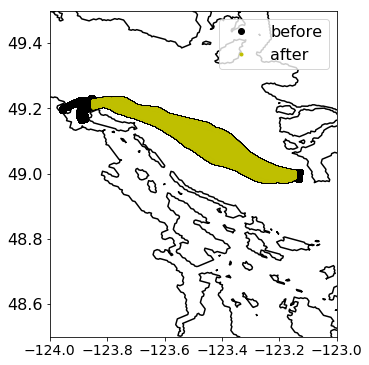

In [5]:
# chop off ends:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
#ax.plot(df['Lon'],df['Lat'], 'ro',label='data')
ax.plot(df['Lon'],df['Lat'], 'ko',label='before')
df.drop(df.loc[(df.Lon<-123.85)|(df.Lon>-123.15)].index,inplace=True)
ax.plot(df['Lon'],df['Lat'],'y.',label='after')
#ax.plot(df2.loc[60,['Lon']],df2.loc[60,['Lat']],'m.')
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 49.5)
ax.legend()
ax.set_xlim(-124., -123);

print('newlen=',len(df))

In [6]:
df.tail()

,index,TimeUTC,CDOM,CDOMQC,Chlorophyll_ug,ChlQC,Turbidity_NTU,TurbQC,Lat,LatQC,Lon,LongQC,dtUTC
10311578,10508563,2018-01-08T16:03:31.403Z,8.004,1,0.5978,1,19.240,1,49.217035,8,-123.806775,8,2018-01-08 16:03:31
10311579,10508564,2018-01-08T16:03:32.475Z,8.280,1,0.5856,1,19.906,1,49.217035,8,-123.806633,8,2018-01-08 16:03:32
10311580,10508565,2018-01-08T16:03:33.549Z,8.464,1,0.6222,1,19.462,1,49.217034,8,-123.806492,8,2018-01-08 16:03:33
10311581,10508566,2018-01-08T16:03:34.622Z,8.372,1,0.6100,1,20.202,1,49.217033,8,-123.806350,8,2018-01-08 16:03:34
10311582,10508567,2018-01-08T16:03:35.694Z,8.096,1,0.5734,1,20.276,1,49.217032,8,-123.806209,8,2018-01-08 16:03:35


In [7]:
def _adelta(x):
    return x.max() - x.min()

_adelta.__name__='delta'

def _crename(xx,cdict):
    return [cdict[x] if x in cdict.keys() else x for x in xx ]

def subsampleFerry(df0,interval,window,nmin,targetVar):
    df0['ts']=(df0['dtUTC']-dt.datetime(1900,1,1)).dt.total_seconds()
    df0.drop(df0[df0.ts%interval+window/2 > window].index, inplace=True)
    df0['tind']=[dt.datetime(1900,1,1)+dt.timedelta(seconds=np.round(aa/interval)*interval) for aa in df0['ts']]
    agg={targetVar:['mean','std','count'],
         'Lat':['mean',_adelta],
         'Lon':['mean',_adelta]}
    df2=df0.groupby(['tind'],as_index=False).agg(agg)
    ndict={'tind':'dtUTC','Chlorophyll_ug_mean':'Chl','Lat_mean':'Lat','Lon_mean':'Lon'}
    df2.columns = _crename(['_'.join(tup).rstrip('_') for tup in df2.columns.values],ndict)
    df2.drop(df2[df2.Chlorophyll_ug_count<nmin].index, inplace=True)
    df2.reset_index(inplace=True)
    return df2

In [8]:
interval=10*60
window=60
nmin=3
targetVar='Chlorophyll_ug'
t0=dt.datetime.now()
df2=subsampleFerry(df,interval,window,nmin,targetVar)
print((dt.datetime.now()-t0))
len(df2)

0:00:16.195959


15629

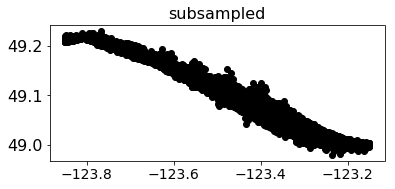

In [9]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
#ax.plot(df['Lon'],df['Lat'], 'ro',label='data')
ax.plot(df2['Lon'],df2['Lat'], 'ko')
ax.set_title('subsampled')

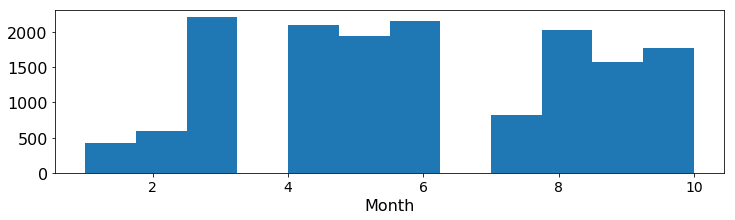

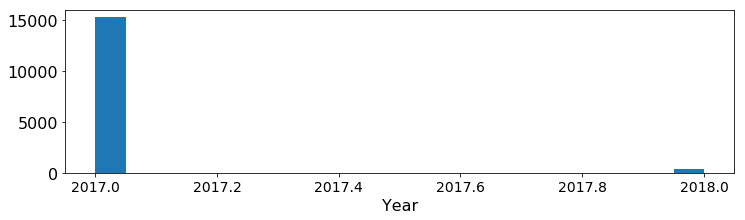

In [10]:
fig,ax=plt.subplots(figsize=(12,3))
ax.hist([xx.month for xx in df2['dtUTC']],12)
ax.set_xlabel('Month')
fig,ax=plt.subplots(figsize=(12,3))
ax.hist([xx.year for xx in df2['dtUTC']],20)
ax.set_xlabel('Year')

In [11]:
df2.tail()

,index,dtUTC,Chl,Chlorophyll_ug_std,Chlorophyll_ug_count,Lat,Lat_delta,Lon,Lon_delta
15624,15638,2018-01-08 14:20:00,0.848952,0.038097,29,49.151370,0.001237,-123.579595,0.003648
15625,15639,2018-01-08 14:30:00,0.652910,0.028541,29,49.175919,0.001203,-123.651933,0.003618
15626,15640,2018-01-08 14:40:00,0.493664,0.014656,28,49.197837,0.000996,-123.725133,0.003584
15627,15641,2018-01-08 14:50:00,0.575503,0.028809,29,49.217438,0.000325,-123.800037,0.004062
15628,15642,2018-01-08 16:00:00,0.554469,0.024743,29,49.213155,0.000755,-123.832206,0.003847


In [12]:
PATH= '/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,1,1) #end of current ONC file is <2017 7 3
flen=1
namfmt='nowcast'
filemap={'diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T'}
fdict={'ptrc_T':1,'grid_T':1}

In [13]:
it0=dt.datetime.now()
print(it0)
data=et.matchData(df2,filemap, fdict, start_date, end_date, namfmt, PATH, flen,wrapSearch=True,wrapTol=12,method='ferry')
print(dt.datetime.now()-it0)

2019-05-03 20:01:04.401010
data is matched to mean of upper 3 model levels
done index ptrc_T 2019-05-03 20:02:04.696657
ptrc_T progress: 0.0%
ptrc_T progress: 10.00065750542442%
ptrc_T progress: 20.00131501084884%
ptrc_T progress: 30.001972516273263%
ptrc_T progress: 40.00263002169768%
ptrc_T progress: 50.0032875271221%
ptrc_T progress: 60.003945032546525%
ptrc_T progress: 70.00460253797094%
ptrc_T progress: 80.00526004339535%
ptrc_T progress: 90.00591754881978%
3:06:32.071515


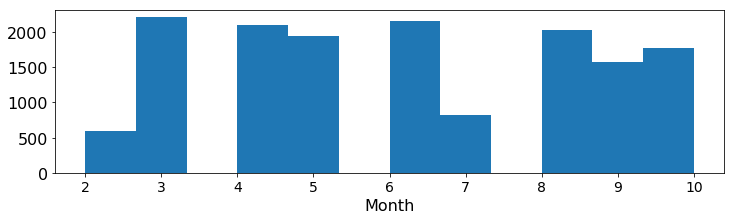

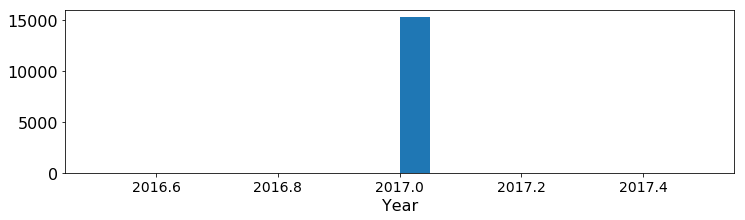

In [14]:
fig,ax=plt.subplots(figsize=(12,3))
ax.hist([xx.month for xx in data['dtUTC']],12)
ax.set_xlabel('Month')
fig,ax=plt.subplots(figsize=(12,3))
ax.hist([xx.year for xx in data['dtUTC']],20)
ax.set_xlabel('Year')

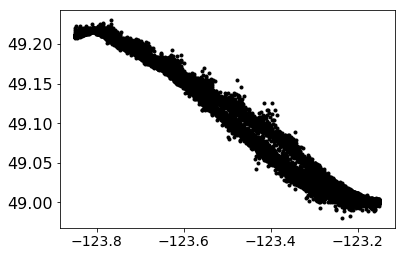

In [15]:
plt.plot(data['Lon'],data['Lat'],'k.')

In [16]:
mod_chl_N=2.0
mod_chl_N=1.6
data['modChl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['l10_obsChl']=np.log10(data['Chl']+0.01)
data['l10_modChl']=np.log10(data['modChl']+0.01)

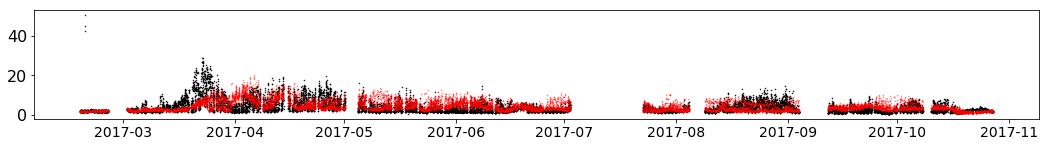

In [17]:
fig,ax=plt.subplots(figsize=(18,2))
ax.plot(data['dtUTC'],data['Chl'],'k.',ms=1)
ax.plot(data['dtUTC'],data['modChl'],'r.',ms=1,alpha=.5)

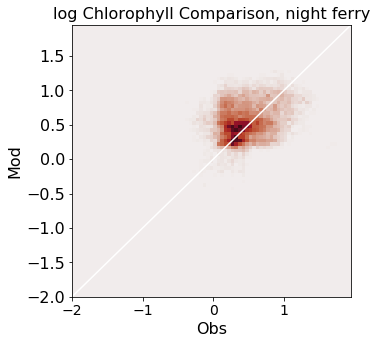

In [18]:
fig,ax=plt.subplots(figsize=(5,5))
ax.hist2d(data['l10_obsChl'],data['l10_modChl'],np.arange(-2,2.0,.05),cmap=cmocean.cm.amp);
ax.set_xlabel('Obs')
ax.set_ylabel('Mod')
ax.plot((-2,2),(-2,2),'w-')
ax.set_title('log Chlorophyll Comparison, night ferry')

In [19]:
def _rmse(delf):
    return np.sqrt(np.mean(np.power(delf,2)))
_rmse.__name__='RMSE'

In [20]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]
    lmask=-1*(tmask[0,0,:,:]-1)

In [21]:
data['ER']=data['l10_modChl']-data['l10_obsChl']
agg={'ER':[_rmse,'mean'],
     'Chl':'count'}
df3=data.groupby(['i','j'],as_index=False).agg(agg)
df3.columns = ['_'.join(tup).rstrip('_') for tup in df3.columns.values]
df3=df3.reindex()

In [22]:
df3

,i,j,ER_RMSE,ER_mean,Chl_count
0,225,486,0.314045,-0.142812,7
1,225,487,0.302456,0.003893,26
2,226,486,0.257687,-0.035058,37
3,226,487,0.280548,-0.001598,126
4,226,488,0.308059,-0.056105,3
5,227,486,0.276484,-0.021188,81
6,227,487,0.252678,-0.006349,68
7,227,488,0.296382,0.056012,3
8,227,489,0.250185,-0.241120,2
9,228,485,0.143140,0.143140,1


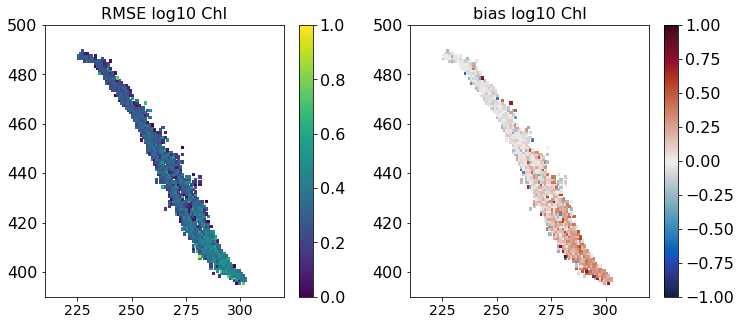

In [23]:
blank=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
blank2=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
for ind, r in df3.iterrows():
    blank[int(r['j']),int(r['i'])]=r['ER_RMSE']
    blank2[int(r['j']),int(r['i'])]=r['ER_mean']
fig,ax=plt.subplots(1,2,figsize=(12,5))
iax=ax[0]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank),vmin=0,vmax=1.)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('RMSE log10 Chl')
iax=ax[1]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank2),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('bias log10 Chl')

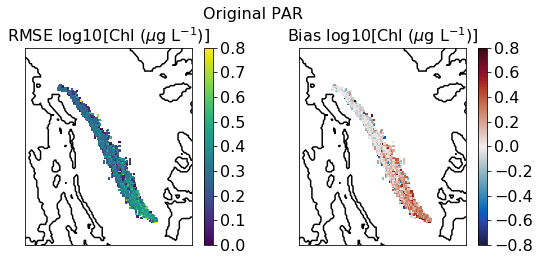

In [31]:
blank=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
blank2=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
for ind, r in df3.iterrows():
    blank[int(r['j']),int(r['i'])]=r['ER_RMSE']
    blank2[int(r['j']),int(r['i'])]=r['ER_mean']
fig,ax=plt.subplots(1,2,figsize=(9,5*3/4))
fig.subplots_adjust(wspace=.2,bottom=.1,top=.83)
iax=ax[0]
viz_tools.set_aspect(iax)
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(iax, grid, coords = 'grid')
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank),vmin=0,vmax=.8)
iax.set_xlim(200,330)
iax.set_ylim(380,515)
iax.set_yticks(());
iax.set_xticks(());
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('RMSE log10[Chl ($\mu$g L$^{-1}$)]')
iax=ax[1]
viz_tools.set_aspect(iax)
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(iax, grid, coords = 'grid')
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank),vmin=0,vmax=.8)
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank2),vmin=-.8,vmax=.8,cmap=cmocean.cm.balance)
iax.set_xlim(200,330)
iax.set_ylim(380,515)
iax.set_yticks(());
iax.set_xticks(());
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
fig.suptitle('Original PAR')
iax.set_title('Bias log10[Chl ($\mu$g L$^{-1}$)]')
fig.savefig('/home/eolson/pyCode/notebooks/figs/ferryChlBiasOldPAR.png',dpi=200,transparent=True)

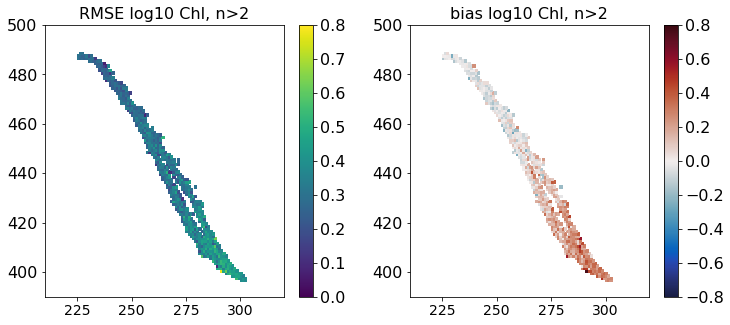

In [26]:
blank=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
blank2=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
for ind, r in df3.iterrows():
    if r['Chl_count']>=3:
        blank[int(r['j']),int(r['i'])]=r['ER_RMSE']
        blank2[int(r['j']),int(r['i'])]=r['ER_mean']
fig,ax=plt.subplots(1,2,figsize=(12,5))
iax=ax[0]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank),vmin=0,vmax=.8)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('RMSE log10 Chl, n>2')
iax=ax[1]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank2),vmin=-.8,vmax=.8,cmap=cmocean.cm.balance)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('bias log10 Chl, n>2')

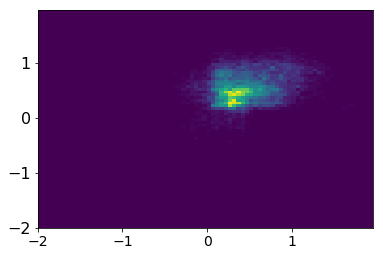

In [25]:
Ns,ex,ey=np.histogram2d(data['l10_obsChl'],data['l10_modChl'],np.arange(-2,2.0,.05));
plt.pcolormesh(ex,ey,Ns.T)